# Objective

Image clustering using the pretrained CNN VGG16.

As motivation the following post was used, but converted to PyTorch.

Source: https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

The dataset contains 210 images of 10 different species of flowers.

Source: https://www.kaggle.com/olgabelitskaya/flower-color-images

![vgg16 architecture](vgg16.png "VGG16 Architecture")

# Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
from PIL import Image

# Read Data

Read images and labels

In [2]:
path = "data/flower_images/flower_images"

# get images and labels
df = pd.read_csv(os.path.join(path, 'flower_labels.csv'))
flowers_filenames = []
# list of images
flowers = []
# list of flowers as numpy arrays
flowers_arrays = []
# list of labels
labels = []
for pathname in glob.glob(os.path.join(path,'*.png')): 
    filename = pathname.split('/')[-1]
    labels.append(df.loc[df['file']==filename, 'label'].iloc[0])
    flowers_filenames.append(pathname)
    im=Image.open(pathname)
    rgb_im = im.convert('RGB')
    flowers.append(rgb_im)
    flowers_arrays.append(np.array(rgb_im))
    
# get the unique labels (from the flower_labels.csv)
unique_labels = list(set(labels))
print(f'nr of labels: {len(labels)}')
print(f'unique labels: {unique_labels}')

nr of labels: 210
unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Example Plots

In [3]:
# check size
print(flowers[0])
print(flowers[0].size)
print(flowers[0].mode)

<PIL.Image.Image image mode=RGB size=128x128 at 0x7FC87F762C70>
(128, 128)
RGB


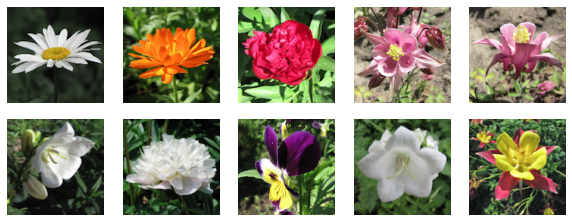

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(10,5))
plt.subplots_adjust(hspace=-0.3)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(flowers[i])
    ax.axis('off')

# Dataset

In [5]:
class FlowerDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        '''
        data: images
        transform: optional transform to be applied on a sample
        '''
        self.imgs = data
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs)
        
    def __getitem__(self, idx):
        img = self.imgs[idx]
        y = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        return img, y      

In [6]:
transform = transforms.Compose([transforms.Resize((224,224)), # input shape for VGG16
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
dataset = FlowerDataset(flowers, np.array(labels), transform)
dataloader = DataLoader(dataset, batch_size=1)
print(f'image dataloader: {next(iter(dataloader))[0].shape}')
print(f'label dataloader: {next(iter(dataloader))[1]}')

image dataloader: torch.Size([1, 3, 224, 224])
label dataloader: tensor([4])


# Model

In [7]:
# load vgg16 model
vgg16 = models.vgg16(pretrained=True)

In [8]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
# remove last layer from classifier of the VGG16 net
features = list(vgg16.classifier.children())[:-1] # Remove last layer
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
data = {}
for batch_idx, (img, _) in enumerate(dataloader):
    vgg16.eval()
    features = vgg16(img)
    data[flowers_filenames[batch_idx]] = features.detach().numpy()

/home/frauke/anaconda3/envs/torchvision/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [11]:
# get a list of the filenames
filenames = np.array(list(data.keys()))
#filenames

In [12]:
# get a list of just the features
feat = np.array(list(data.values()))
feat.shape

(210, 1, 4096)

In [13]:
# reshape so that there are all samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape

(210, 4096)

# Dimensionality Reduction

Use a PCA to reduce the dimensionality from 4096 to 210. PCA allows you to reduce the number of variables while preserving as much information from the original set as possible.

In [14]:
pca = PCA(n_components=210, random_state=22)
pca.fit(feat)
x = pca.transform(feat)
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 210


# KMeans Clustering

Use KMeans clustering in order to cluster the images. In this case we have 10 flower classes, that is we will cluster into 10 (len(unique_labels)) groups.

In [15]:
kmeans = KMeans(n_clusters=len(unique_labels), random_state=22)
kmeans.fit(x)

KMeans(n_clusters=10, random_state=22)

In [16]:
# have a look at the predicted labels
kmeans.labels_

array([2, 1, 4, 7, 7, 8, 9, 3, 8, 1, 8, 5, 2, 4, 7, 4, 1, 9, 3, 2, 4, 2,
       3, 2, 0, 2, 9, 5, 4, 1, 2, 8, 9, 2, 4, 1, 4, 9, 1, 6, 8, 4, 5, 4,
       5, 0, 9, 7, 4, 1, 0, 8, 4, 5, 4, 4, 7, 4, 7, 4, 5, 7, 5, 1, 4, 0,
       5, 3, 8, 6, 9, 8, 1, 5, 5, 0, 4, 5, 9, 6, 7, 5, 4, 8, 8, 3, 0, 3,
       2, 3, 7, 2, 1, 9, 8, 3, 9, 6, 4, 8, 2, 4, 5, 3, 4, 9, 0, 7, 4, 5,
       2, 4, 2, 1, 7, 5, 4, 3, 4, 4, 0, 5, 9, 4, 4, 9, 9, 7, 6, 7, 5, 1,
       4, 4, 1, 3, 4, 1, 9, 7, 4, 8, 4, 9, 1, 1, 9, 9, 5, 7, 3, 1, 3, 0,
       3, 5, 4, 7, 4, 5, 4, 3, 0, 3, 3, 4, 4, 5, 1, 1, 3, 9, 8, 1, 0, 5,
       7, 3, 0, 4, 7, 0, 7, 7, 7, 3, 7, 3, 0, 4, 3, 8, 2, 7, 3, 2, 2, 2,
       0, 5, 4, 3, 9, 3, 7, 2, 8, 2, 9, 2], dtype=int32)

Each label in this list is a cluster identifier for each image in our dataset. The order of the labels is parallel to the list of filenames for each image. This way we can group the images into their clusters.

In [17]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(flowers_filenames, kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [18]:
for i in range(len(groups)):
    print(len(groups[i]))

15
20
20
25
41
23
5
24
16
21


# Plot Results

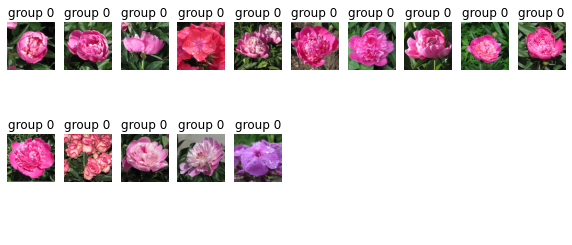

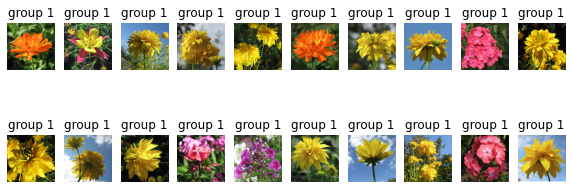

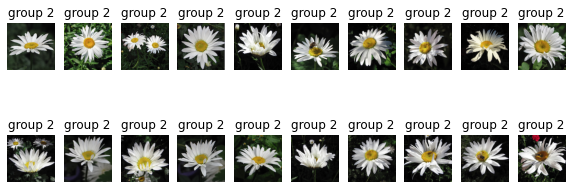

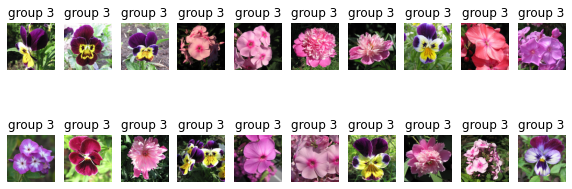

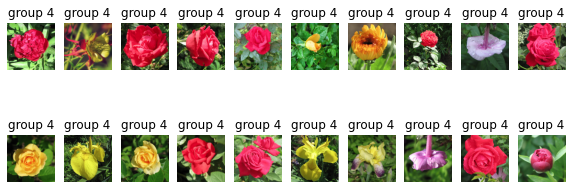

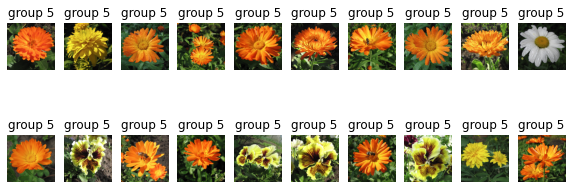

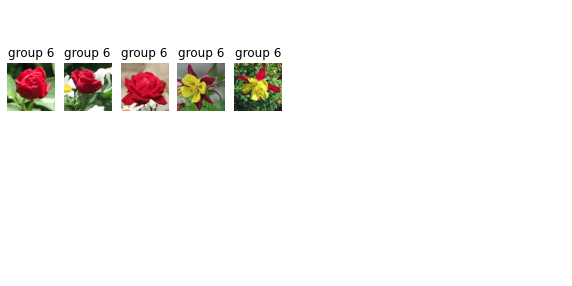

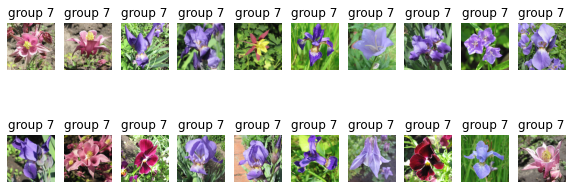

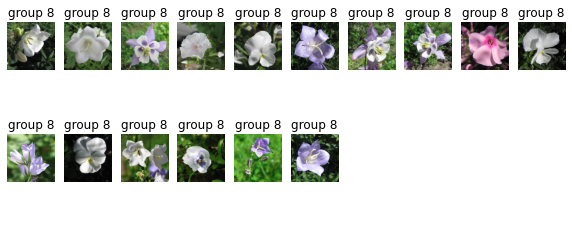

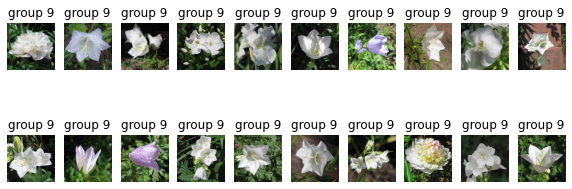

In [19]:
for i in range(len(groups)):
    nr = len(groups[i])
    fig, axes = plt.subplots(2, 10, figsize=(10,5))
    plt.subplots_adjust(hspace=-0.3)
    for j, ax in enumerate(axes.flatten()):
        if len(groups[i])> j:
            im=Image.open(groups[i][j])
            ax.imshow(im)
            ax.set_title(f'group {i}')
            ax.axis('off')
        else:
            ax.axis('off')